# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit your completed notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment

In [ ]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from IPython.display import display

# To get geo info of IP addresses:
#!pip install maxminddb-geolite2
from geolite2 import geolite2

seed = 2023
np.random.seed(seed)
import sys
np.set_printoptions(threshold=sys.maxsize)

## Question 1: /20 pts

The dataset `customer_data.csv` lists certain attributes providing valuable insights into customer behavior and demographics:

- **full.name**: Customer's full name
- **ip.address**: Customer's IP address
- **region**: Customer's geographical region
- **age**: Customer's age
- **items**: Number of items purchased by the customer
- **amount**: The total amount spent by the customer

Businesses can leverage this dataset to make data-driven decisions, understand customer preferences, and tailor their strategies to meet customer needs and interests.


### 1.1 Load the dataset and display the first 5 rows.

In [87]:
#your code here
df = pd.read_csv("customer_data.csv")
df.head()

,full.name,ip.address,region,in.store,age,items,amount
0,Carter Stokes,NaN,2,0,37,4,281.03
1,Jacob Jerde,NaN,2,0,35,2,219.51
2,Tressa Ratke,192.90.208.202,4,1,45,3,1525.70
3,Rudolf Abshire,251.55.128.164,3,1,46,3,715.25
4,Theresa Davis,182.19.192.186,1,1,33,4,1937.50


### 1.2 First, remove any rows where the entry of "Age" column is below 18 or above 80, and then extract two new features from `ip.address`: one called `latitude` and the other `longitude`. Use the package `geolite2` for the conversion of the IP addresses to latitude and longitude. Use [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to do the conversion (in a vectorized way) in one go for each new feature. Avoid using `for` loops. At the end, drop the column `ip.address` as well as any rows with a missing value. Display the first 5 rows of the new dataframe and report its shape.

In [88]:
#your code here
df = df.drop(df[df['age']>80].index).drop(df[df['age']<18].index)

In [89]:
# extract ip.address
def getLoc(ip):
    try:
        location = geolite2.reader().get(ip)
        if location and 'location' in location:
            return pd.Series([location['location']['latitude'], location['location']['longitude']])
        else:
            return pd.Series([None, None])
    except Exception:
        return pd.Series([None, None])
df[['latitude', 'longitude']] = df['ip.address'].apply(getLoc)
df = df.drop(columns=['ip.address'])
df = df.dropna()
df.head()



,full.name,region,in.store,age,items,amount,latitude,longitude
2,Tressa Ratke,4,1,45,3,1525.70,42.5879,-71.3498
4,Theresa Davis,1,1,33,4,1937.50,1.2931,103.8558
7,Keitha Mosciski,3,1,66,5,819.98,40.0842,-82.9378
8,Hortense Streich,1,1,51,5,908.31,37.7510,-97.8220
9,Carl Price,1,1,47,3,767.54,41.3969,-87.3274


### 1.3 Perform one-hot encoding on the `region` column using pd.get_dummies(). Display the first 5 rows of the encoded dataframe.

In [90]:
#your code here
encoded_df = pd.get_dummies(df, columns=['region'])
encoded_df.head()

,full.name,in.store,age,items,amount,latitude,longitude,region_1,region_3,region_4
2,Tressa Ratke,1,45,3,1525.70,42.5879,-71.3498,False,False,True
4,Theresa Davis,1,33,4,1937.50,1.2931,103.8558,True,False,False
7,Keitha Mosciski,1,66,5,819.98,40.0842,-82.9378,False,True,False
8,Hortense Streich,1,51,5,908.31,37.7510,-97.8220,True,False,False
9,Carl Price,1,47,3,767.54,41.3969,-87.3274,True,False,False


### 1.4 Calculate the natural logarithm of the column reporting clients' total amount spent and store it as a new column `log_amount`. Create your design matrix `X` and target vector `y` with `log_amount` as target (No training/test splitting yet).



In [91]:
#your code here
encoded_df["log_amount"] = np.log(encoded_df["amount"])
X = encoded_df.drop(columns=["amount", 'log_amount'])
y = encoded_df["log_amount"]

### 1.5 Build a new design matrix by applying polynomial expansion using `PolynomialFeatures()` on `X` with degree=2. Do not include the column with power 0 (*i.e.*, the column with all elements being 1) and make sure to not set the argument `interaction_only` to `True`.


In [92]:
#your code here
poly_X = PolynomialFeatures(degree=2, interaction_only=False)
Xtmp = X.loc[:, X.ne(1).any()].drop(columns=['full.name'])
poly_X = poly_X.fit_transform(Xtmp)


### 1.6 Standardize your design matrix from Question 1.5 using `StandardScaler()`, and store the result as a Pandas dataframe.

In [93]:
#your code here
scaler = StandardScaler()
scaler.fit(poly_X)
scaler = scaler.transform(poly_X)

## Question 2: /7 pts



### 2.1 Split the data into training and test sets. Hold out 30% of observations as the test set. How many observations are in your training dataset? What is the average value of the target variable in the training dataset (rounded to 2 decimal places)?

In [94]:
#your code here
X_train, X_test, y_train, y_test = train_test_split(poly_X,y , random_state=seed,  test_size=0.3)
np.shape(X_train), np.round(np.average(y_train), 2)

((24012, 36), 6.38)

## Question 3: /23 pts



### 3.1 Create a SciKit Learn `Ridge` regression object. Train it on the training data using an `alpha` of $4.0$ and do fit the intercept.

In [95]:
#your code here
ridgeReg = skl.Ridge(alpha = 4.0, fit_intercept=True)
ridgeReg = ridgeReg.fit(X_train, y_train)
ridgeReg.score(X_test, y_test)

0.09912420162829139

### 3.2 Now use `RidgeCV` to find the best `alpha` for the penalty term through a 5-fold cross-validation. As input for `alpha`, your code must try integer values from 30 to 50 inclusive. Report the `alpha` that yields the smallest loss.

In [96]:
#your code here
alphaList = list(range(30,51,1))
ridgeReg = skl.RidgeCV(alphas=alphaList, cv=5, fit_intercept=True).fit(X_train, y_train)
best_alpha = ridgeReg.alpha_
best_alpha


30

### 3.3 Fit a `Ridge` regression on the training data with the best `alpha` found in the previous question.

In [97]:
#your code here
bestAlpha_reg = skl.Ridge(alpha = best_alpha, fit_intercept=True)
ridgeReg = ridgeReg.fit(X_train, y_train)
ridgeReg.score(X_test, y_test)

0.09915329344122359

### 3.4 Fit a simple `LinearRegression` without any penalty using the training data (again, `fit_intercept=True`). Compare the regression coefficients obtained in questions 3.1, 3.3 and 3.4. How do they compare?

In [98]:
#your code here

linearReg = skl.LinearRegression(fit_intercept=True)
linearReg = linearReg.fit(X_train, y_train)
linearReg.score(X_test, y_test)


0.09907518880735766

#### YOUR ANSWER HERE

Ridge regression has the highest score, and the ridge model with best alpha has a highest score.


### 3.5 Use your trained linear regression models in Q3.3 and Q3.4 to predict over the test set and print the median of their perdictions.

In [99]:
#your code here
linear_y_pred = linearReg.predict(X_test)
np.median(linear_y_pred)

6.388824455672875

## Question 4: /25 pts



### 4.1 Fit a Lasso regression to the train dataset using lasso_path(). Show the full path of the first 20 coefficients of the Lasso regression. Include eps=8e-3 and n_alphas=50. Describe the trends you see in the figure.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


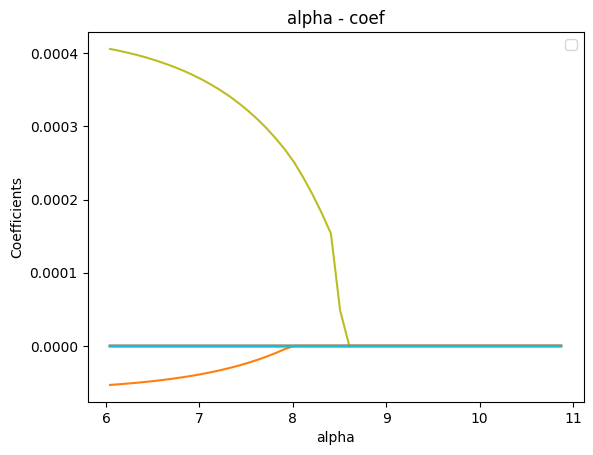

In [100]:
#your code here
lasso_alpha, lasso_coef, _ = skl.lasso_path(X_train, y_train, eps=8e-3, n_alphas=50)
plt.figure()
for i in range(20):  
    plt.plot(np.log(lasso_alpha), lasso_coef[i])
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title("alpha - coef")
plt.legend()
plt.show()


The coefficient converges to zero as alpha increase

### 4.2 Use Scikit Learn's cross-validated LASSO to automatically search for the best alpha of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameters and the number of coefficients that the model shrinks to zero.

In [101]:
#your code here
lassoReg = skl.LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed)
lassoReg = lassoReg.fit(X_train, y_train)
lassoReg.alpha_, sum(lassoReg.coef_ == 0)

(1.5075114078835974, 30)


### 4.3 Use Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the ElasticNet regression (with intercept) on the training set. Include the same arguments as in question 4.2 as well as `l1_ratio=[0.7, 0.9, 0.95, 0.99, 1]`. Report the best tuning parameters. Is the ElasticNet regression model equivalent to the Lasso regression? Briefly describe how they defer and under what circumstances they become the same.

In [102]:
#your code here
elasticReg = skl.ElasticNetCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, l1_ratio=[0.7, 0.9, 0.95, 0.99, 1])
elasticReg.fit(X_train, y_train)
elasticReg.alpha_,elasticReg.l1_ratio_

(1.5075114078835974, 1.0)

#### YOUR ANSWER HERE

No. Elastic Net is equivelent to Lasso only if L1 = 1.

## Question 5 : /16 pts



### 5.1 Use `SequentialFeatureSelector()` to conduct forward selection for the features of the Ridge model tuned in Q 3.3. Include the argument `n_features_to_select=20`. Report the indices of the selected features.

In [ ]:
#your code here
sfs = sk.feature_selection.SequentialFeatureSelector(ridgeReg, n_features_to_select=20)
sfs.fit(X_train, y_train)
selected_features_indices = sfs.get_support(indices=True)
selected_features_indices


### 5.2 Fit a regular `LinearRegression` (with `fit_intercept=True`) on the training set using the selected features from the previous question. Print the first 3 coefficients of your model.

In [ ]:
#your code here
X_train_selected = X_train[:, selected_features_indices]
selected_linReg = skl.LinearRegression(fit_intercept=True)
selected_linReg.fit(X_train_selected, y_train)
coeffs = selected_linReg.coef_
coeffs[:3]

array([0.        , 0.00239144, 0.1218949 ])

## Question 6: /9 pts



### 6.1 Make predictions on the test set using models from questions 3.3, 4.2, 4.3, and 5.2, respectively. Create a DataFrame with  predicted values obtained from the different models. Name the columns of the dataframe consistent with the names used for the models, or their question number. Display the first 5 rows of this dataframe.

In [ ]:
#your code here
ridge_preds = ridgeReg.predict(X_test)
lasso_preds = lassoReg.predict(X_test)
elastic_preds = elasticReg.predict(X_test)
lin_reg_selected_preds = selected_linReg.predict(X_test[:, selected_features_indices])
predictions = pd.DataFrame({'Ridge': ridge_preds,
                            'Lasso': lasso_preds,
                            'ElasticNet': elastic_preds,
                            'SelectedLinear': lin_reg_selected_preds}) 
predictions.head()  

,Ridge,Lasso,ElasticNet,SelectedLinear
0,6.050352,6.114141,6.114141,6.066551
1,5.975529,6.037253,6.037253,5.999697
2,6.041700,5.950847,5.950847,6.012180
3,6.068506,6.026278,6.026278,6.063514
4,6.348587,6.324437,6.324437,6.324854


### 6.2 Use `mean_squared_error` as your scorer to assess the performance of the different models (those reported in the previous question) based on all the predicted values over test set. Based on this scorer which model is the best?

In [ ]:
#your code here
ridge_mse = metrics.mean_squared_error(y_test, ridge_preds)
lasso_mse = metrics.mean_squared_error(y_test, lasso_preds)
elastic_mse = metrics.mean_squared_error(y_test, elastic_preds)
lin_reg_selected_mse = metrics.mean_squared_error(y_test, lin_reg_selected_preds)

mse_values = {
    'Ridge': ridge_mse,
    'Lasso': lasso_mse,
    'ElasticNet': elastic_mse,
    'LinRegSelected': lin_reg_selected_mse
}

mse_values


{'Ridge': 0.6026518792858427,
 'Lasso': 0.6180425773764266,
 'ElasticNet': 0.6180425773764266,
 'LinRegSelected': 0.6024416778063885}

#### YOUR ANSWER HERE

ElasticNet has best performance.